```mermaid
graph TD
a(三元阵列数据)--线性预测虚拟阵元在三阵元间补阵元, 减小阵元间距--> b(阵元间距小于半波长/宽带互谱最大距离的N元阵列数据)
b--stft-->c(时频图)--求相位-->d(时相图, 宽带互谱相位导数指示时延信息, 此处考虑用attention/蒙版聚焦脉冲)-->h(方向)
c--分频段istft然后常规/MVDR波束形成扫描--> e(方位谱)-->h
c--求幅度-->f(时频幅图, 或者用线性倒谱系数求频谱包络?, 多频点能量指示脉冲起振时刻)-->g(各通道起振粗测值)
g--给出关键帧, 缩小时域关注范围 (给蒙版?)-->d
```

宽带信号互谱法要求$d\le \frac{c}{2B}$, 当带宽B=500Hz, d_max = 1.5m

In [1]:
import os

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch import nn

from torchmetrics import Accuracy
import torchmetrics
from torchkeras import KerasModel

from matplotlib import pyplot as plt
from scipy import signal

from entity import *

## 数据准备

### 数据处理

先分批将每个样本中数据按时间窗转为频相图, 作为特征

In [2]:
c = 1500
fc = 42500
fs_factor = 8
fs = fs_factor * fc
d = 0.5
K = 1.0
SNR = 30.0
dist_max = d * (K + 1)
maxlag = int(np.ceil(dist_max / c * fs))  # 当前采样频率下最大滞后量
sample_interval = 1

dataset_path = f'/run/media/leo/HP P900/dataset/fc_{fc}-fs_factor_{fs_factor}-d_{d}-K_{K}-SNR_{SNR}'
train_path = f'{dataset_path}/train'
val_path = f'{dataset_path}/val'

In [3]:
class STFT_Phase(nn.Module):
    def __init__(self, fs, nfft):
        super().__init__()
        self.nfft = nfft
        f_low = 20e3
        f_high = 60e3
        f = np.linspace(0,fs / 2,int(nfft/2+1))
        f_idx = np.argwhere((f > f_low) & (f < f_high)).squeeze()
        self.f_low = f_idx[0]
        self.f_high = f_idx[-1]

    def forward(self, x):
        batch_size, seconds, channels, t_len = x.shape
        Zxx = torch.stft(
            x.view(-1, t_len),   # 压平秒窗, 并行计算
            n_fft=self.nfft,
            hop_length=int(self.nfft/4),
            window=torch.hann_window(self.nfft, device=x.device),
            onesided=True,
            return_complex=True
        )  # shape: (batch_size * seconds * channels, freq, time)
        Zxx = Zxx[:, self.f_low:self.f_high, :]
        Zxx = Zxx.reshape(-1, channels, Zxx.shape[-2], Zxx.shape[-1])  # shape: (batch_size * seconds, channels, freq_limited, time)
        R12_23_13 = torch.stack((Zxx[:, 0, :, :] * torch.conj(Zxx[:, 1, :, :]), Zxx[:, 1, :, :] * torch.conj(Zxx[:, 2, :, :]), Zxx[:, 0, :, :] * torch.conj(Zxx[:, 2, :, :])), dim=1)  # shape: (batch_size * seconds, 3, freq_limited, time)
        phase12_23_13 = torch.angle(R12_23_13).view(batch_size, seconds, 3, Zxx.shape[-2], Zxx.shape[-1])  # shape: (batch_size, seconds, 3, freq_limited, time)
        return phase12_23_13

In [4]:
def process_data():
    class ArrDataSet(Dataset):
        def __init__(self, folder_path):
            # folder_path下所有文件的列表
            self.folder_path = folder_path
            self.filenames = os.listdir(folder_path)

        def __len__(self):
            return len(self.filenames)

        def __getitem__(self, idx):
            dataDict = np.load(f'{self.folder_path}/{self.filenames[idx]}')
            data, fs, rs, angles = dataDict['data'], dataDict['fs'], dataDict['rs'], dataDict['angles']
            data = torch.tensor(data, dtype=torch.float32)
            rs = torch.tensor(rs, dtype=torch.float32).reshape(1, -1)
            angles = torch.tensor(angles, dtype=torch.float32).reshape(1, -1)
            return data, rs, angles, self.filenames[idx]


    stft_phase = STFT_Phase(fs, 8192).to('cuda')

    for folder_path in [train_path, val_path]:
        if not os.path.exists(f'{folder_path}_phase'):
            os.makedirs(f'{folder_path}_phase')
        batch_size = 100
        dl = DataLoader(ArrDataSet(folder_path), batch_size=batch_size, shuffle=False, num_workers=8, drop_last=False)
        print('batch ', end='')
        for batch, (data_arr, rs_arr, angles_arr, filenames) in enumerate(dl):
            phase_arr = stft_phase(data_arr.to('cuda')).cpu().detach()
            theta_arr = torch.deg2rad(angles_arr)
            label_arr = torch.stack([torch.cos(theta_arr), torch.sin(theta_arr)]).squeeze(2).permute(1,0,2)
            for i, filename in enumerate(filenames):
                phase = phase_arr[i].numpy().astype(np.float32)  # shape: (batch_size, 3, freq_limited, time)
                label = label_arr[i].numpy().astype(np.float32)  # shape: (batch_size, 2, seconds)
                np.savez(f'{folder_path}_phase/{filename[:-4]}.npz', data=phase, label=label)
            print(f'{batch},', end='')
        print(f'\n{folder_path} done')

# process_data()

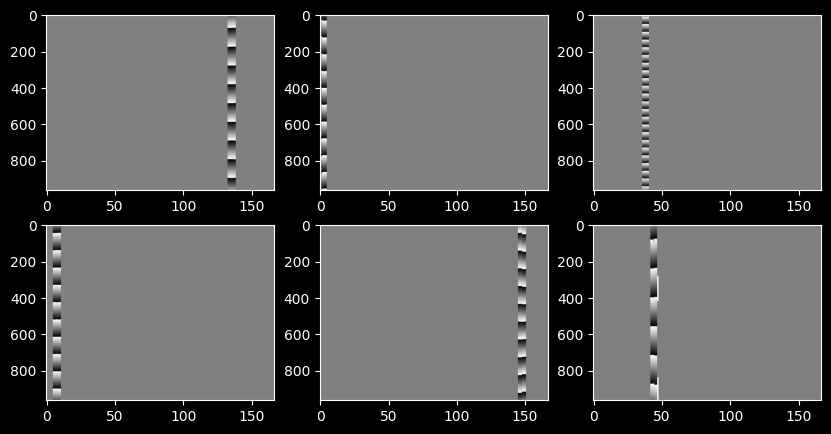

In [5]:
class FeaturesDataSet(Dataset):
    def __init__(self, folder_path):
        # folder_path下所有文件的列表
        self.filepaths = [f'{folder_path}/{filename}' for filename in os.listdir(folder_path)]

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        # tensors = torch.load(self.filepaths[idx])
        arrays = np.load(self.filepaths[idx])
        data = arrays['data'][0]  # shape: (3, f_len, t_len)
        data = (data + np.pi) / (2 * np.pi)  # 归一化到[0, 1]
        # label = arrays['label'][:, 0] * 10  # 以r增大标签值便于梯度下降
        label = arrays['label'][:, 0]
        label = torch.tensor(np.rad2deg(np.arctan2(label[1], label[0]))) - 15
        label = nn.functional.one_hot(label.to(torch.int64), num_classes=151).float()
        return data, label

ds_train = FeaturesDataSet(train_path + '_phase')
ds_val = FeaturesDataSet(val_path + '_phase')
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(ds_train[i][0][i], aspect='auto', cmap='gray')
    plt.subplot(2, 3, i+4)
    plt.imshow(ds_val[i][0][i], aspect='auto', cmap='gray')

In [6]:
batch_size = 25
# 取样时有打乱
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)

In [7]:
class CNN2D(nn.Module):
    def __init__(self, phase_channels, f_channels, t_channels):
        super().__init__()
        self.f_channels, self.t_channels = f_channels, t_channels
        self.layers = nn.ModuleList([
            nn.Conv2d(phase_channels, 8 * phase_channels, (7, 1), groups=phase_channels),  # f维度8通道特征
            nn.AdaptiveAvgPool2d((128, t_channels)),
            nn.Conv2d(8 * phase_channels, 4 * 8 * phase_channels, (1, 3), groups=phase_channels),  # t维度4通道特征
            nn.Conv2d(4 * 8 * phase_channels, 4, 1),  # phase维度4通道特征
            nn.AdaptiveMaxPool2d((64, 256)),
            # nn.ReLU(),
            nn.Flatten(),
            nn.Linear(65536, 1024),
            # nn.ReLU(),
            nn.Linear(1024, 151),
            # nn.LogSoftmax(dim=1)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        # x = x / torch.norm(x) * 10
        # x = torch.tanh(x)  # 应当输出的是单位向量, 因此将输出归一化到(-1，1), 简单约束下# FIXME: 改用归一化层
        return x

In [8]:
# del net

In [9]:
# net = CNN2D(3, 167, 963)
# x = net(torch.randn(5, 3, 167, 963))

## 模型训练

<<<<<< ⚡️ cuda is used >>>>>>


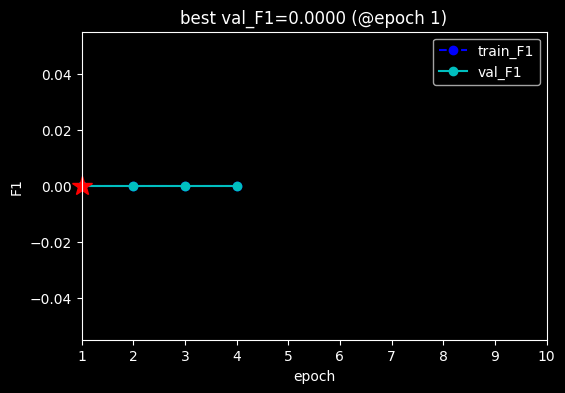

KeyboardInterrupt: 

In [10]:
from torchkeras.models import ResNet50

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(0.0)

# net = CNN2D(3, 167, 963)
net = ResNet50(num_classes=151)
# net.apply(init_weights)  # 初始化权重为全零

# optimizer=optim.SGD(net.parameters(), lr=1e-1)  # TODO: 试试Adam
optimizer=optim.Adam(net.parameters(), lr=1e0)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)


model = KerasModel(
    net,
    # loss_fn=loss_with_regulation,
    # loss_fn=nn.L1Loss(),
    # loss_fn=nn.MSELoss(),
    loss_fn=nn.CrossEntropyLoss(),
    # metrics_dict={'L1': torchmetrics.MeanAbsoluteError(), 'mse': torchmetrics.MeanSquaredError()},
    metrics_dict={
        'acc': Accuracy(task='multiclass', num_classes=151),
        'F1': torchmetrics.F1Score(task='multiclass', num_classes=151),
    },
    optimizer=optimizer,
    # lr_scheduler=lr_scheduler
)

model.fit(
    dl_train,
    dl_val,
    epochs=100,
    ckpt_path='exp/checkpoint',
    patience=10,
    monitor='val_F1',
    mode='max',
)

## 模型评估

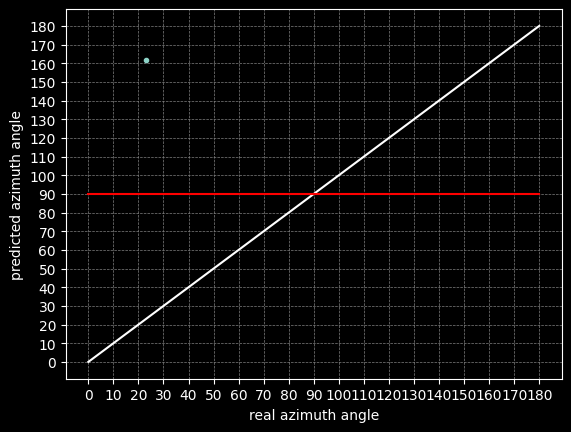

In [ ]:
device = torch.device('cuda')
net = model.net
net.eval()

net.to(device)
data, label = FeaturesDataSet(val_path + '_phase')[np.random.randint(0, 400)]
data = torch.tensor(data).to(device)
output = net(data.unsqueeze(0))
predicted = output.detach().cpu().numpy()
predicted_angles = np.argmax(predicted, axis=1) + 15
label_angles = label.argmax().numpy() + 15
# predicted_angles = np.rad2deg(np.arctan2(predicted[0, 1], predicted[0, 0]))
# label_angles = np.rad2deg(np.arctan2(label[1], label[0]))
plt.plot(label_angles, predicted_angles, '.')
# plt.plot([np.min(np.stack((label_angles, predicted_angles))), np.max(np.stack((label_angles, predicted_angles)))], [np.min(np.stack((label_angles, predicted_angles))), np.max(np.stack((label_angles, predicted_angles)))], 'r')
plt.plot([0, 180], [0, 180], 'white')
plt.plot([0, 180], [90, 90], 'red')

plt.xlabel('real azimuth angle')
plt.ylabel('predicted azimuth angle')
plt.xticks(np.arange(0, 190, 10))
plt.yticks(np.arange(0, 190, 10))
plt.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)

In [ ]:
label.argmax()+15

tensor(134)